In [1]:
# Jupyter commands used to auto-reload packages
%load_ext autoreload
%autoreload 2

# Import dependencies
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit, OptimizeWarning

# Make plots larger
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
## loading required packages  

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
## loading the data
ifile = 'Production.csv'
df_prod = pd.read_csv(ifile)

In [44]:
df_prod.head()

,Well ID,DAYS,OIL,GAS,WATER
0,1,0,630.868000,1157.095194,66.671992
1,1,31,552.874349,1444.594307,33.964977
2,1,61,556.648235,1160.644566,0.000000
3,1,92,440.915721,1238.730745,0.000000
4,1,122,340.278752,1029.317811,0.000000


## First 8 wells

#### Two different models are trained, one for the first 8 wells with available month data and another for the last 4 wells with daily production data

In [45]:
## this function gets the historical data, ie, production data before one time step

def get_history(wid, n_months, phase): ## input desired well, months for hindcast and phase
    data=df_prod[['%s'%phase]].loc[df_prod['Well ID']==wid]   ##subsetting 
    data.reset_index(drop=True, inplace=True)
    hist=(df_prod['%s'%phase].loc[df_prod['Well ID']==wid]).shift(1, axis=0).values
    data['%s_hist'%phase]=hist
    data.dropna(inplace=True)
    train, test= data.iloc[:n_months-1,:], data.iloc[n_months-1,:]  ## train-test split
    return train, test

In [47]:
## sample
train, test=get_history(wid=6,n_months=18,phase='OIL')
train.head()

,OIL,OIL_hist
1,780.645161,37.900000
2,570.000000,780.645161
3,436.571429,570.000000
4,294.000000,436.571429
5,323.266667,294.000000


In [48]:
test

OIL          84.677419
OIL_hist    104.300000
Name: 18, dtype: float64

In [ ]:
## Using a random forest regressor to forecast oil, gas and water production for 6, 12 and 18 months from their historical 
## data for the forst 8 wells

well=[]
fluid_phase=[]
hind_rmse=[]

for n_months in [6,12,18]:
    error=[]
    for wid in range (1,9):
        for phase in ['OIL', 'GAS', 'WATER']:
            well.append(wid)
            fluid_phase.append(phase)
            train, test=get_history(wid=wid,n_months=n_months,phase=phase)
            trainx=train.values[:,1].reshape(len(train), 1)
            trainy=train.values[:,0].reshape(len(train), 1)
            testx=np.array(test.values[1]).reshape(1,1)
            testy=np.array(test.values[0]).reshape(1,1)
            rf=RandomForestRegressor(n_estimators=1000)
            rf.fit(trainx, trainy)
            yhat=rf.predict(testx)
            rmse=np.sqrt(np.mean((testy - yhat) ** 2))
            error.append(rmse)
    hind_rmse.append(error)
            
            

In [ ]:
## compiling the rmse for the different scenarios

df_rmse=pd.DataFrame()
df_rmse['Well ID']=well[0:24]
df_rmse['Phase']=fluid_phase[0:24]
df_rmse['hind_6_months_rmse']=hind_rmse[0]
df_rmse['hind_12_months_rmse']=hind_rmse[1]
df_rmse['hind_18_months_rmse']=hind_rmse[2]


In [51]:
df_rmse['Average_hind_rmse'] = df_rmse.iloc[:, 2:].mean(axis=1) ##getting avg rmse
df_rmse.head()

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
0,1,OIL,75.076437,86.525150,20.533087,60.711558
1,1,GAS,100.787960,222.602399,80.254845,134.548401
2,1,WATER,0.000000,11.950640,16.696635,9.549092
3,2,OIL,55.177363,17.905833,1.649417,24.910871
4,2,GAS,2.970824,9.676925,1.181115,4.609622


In [52]:
df_rmse.to_pickle('rmse_8_wells.p') ##saving the result for 8 wells 


In [5]:
df_rmse_8 = pd.read_pickle('rmse_8_wells.p') ## loading results
#df_rmse_8.head()

In [6]:
df_arps=pd.read_pickle('rmse_arps.p')
df_arps_8=df_arps.loc[df_arps['Well ID']<9]

Text(0.5, 1.0, 'Oil Phase')

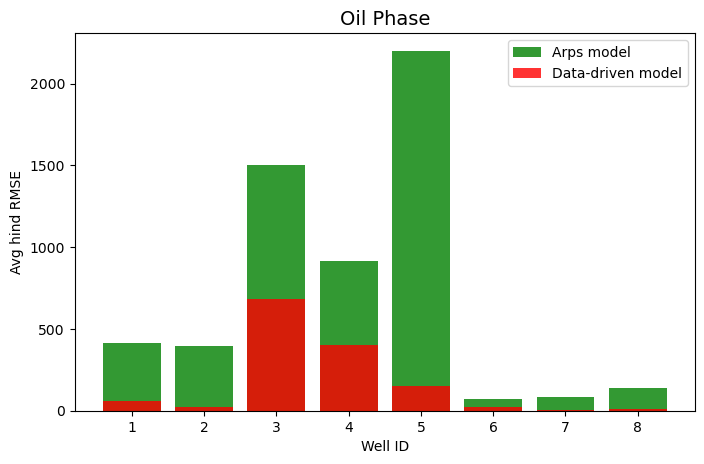

In [36]:
phase='OIL' ## try other phases here

plt.figure(figsize=[8,5])
x=np.unique(df_rmse_8['Well ID'])
y1=df_arps_8['Average_hind_rmse'].loc[df_arps_8['Phase']==phase]
y2=df_rmse_8['Average_hind_rmse'].loc[df_rmse_8['Phase']==phase]
plt.bar(x, y1, color='g',alpha=0.8)
plt.bar(x, y2, color='r',alpha=0.8)
plt.xlabel('Well ID')
plt.ylabel('Avg hind RMSE')
plt.legend(['Arps model', 'Data-driven model'], loc='upper right')
plt.title('Oil Phase', fontsize=14)

Text(0.5, 1.0, 'Gas Phase')

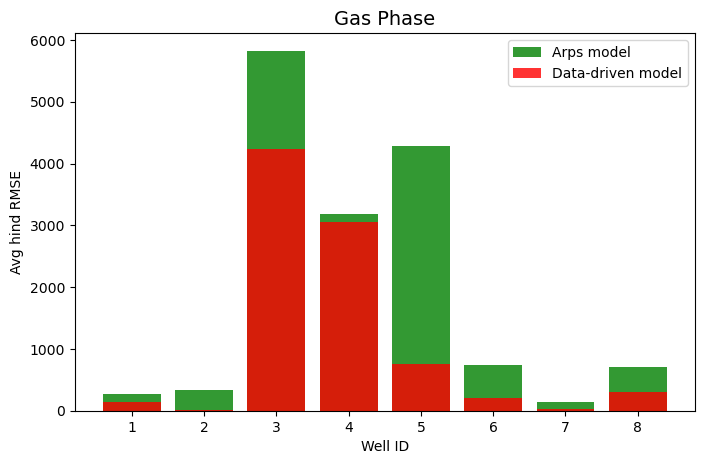

In [35]:
phase='GAS' ## try other phases here

plt.figure(figsize=[8,5])
x=np.unique(df_rmse_8['Well ID'])
y1=df_arps_8['Average_hind_rmse'].loc[df_arps_8['Phase']==phase]
y2=df_rmse_8['Average_hind_rmse'].loc[df_rmse_8['Phase']==phase]
plt.bar(x, y1, color='g', alpha=0.8)
plt.bar(x, y2, color='r',alpha=0.8)
plt.xlabel('Well ID')
plt.ylabel('Avg hind RMSE')
plt.legend(['Arps model', 'Data-driven model'], loc='upper right')
plt.title('Gas Phase', fontsize=14)

## prediction for last 4 wells

#### Repeating the above process for the last 4 wells with daily production. The daily production of the last month is predicted 

In [58]:
def get_history(wid, n_days, phase):
    data=df_prod[['DAYS','%s'%phase]].loc[df_prod['Well ID']==wid]
    data.reset_index(drop=True, inplace=True)
    hist=(df_prod['%s'%phase].loc[df_prod['Well ID']==wid]).shift(1, axis=0).values
    data['%s_hist'%phase]=hist
    data.dropna(inplace=True)
    #print(data)
    train, test= data.iloc[:n_days-1,:], data.iloc[n_days-1:n_days+30,:]
    return train, test

In [59]:
train, test= get_history(wid=10, n_days=17*30, phase='OIL')

In [60]:
test

,DAYS,OIL,OIL_hist
510,534,8.302948,9.036289
511,535,7.138973,8.302948
512,536,6.647313,7.138973
513,537,9.799998,6.647313
514,538,9.472024,9.799998
515,539,10.318084,9.472024
516,540,11.925940,10.318084
517,541,12.058632,11.925940
518,542,11.627599,12.058632
519,543,12.184990,11.627599


In [102]:

well=[]
fluid_phase=[]
hind_rmse=[]

month=30
for n_days in [5*month,11*month,17*month]:
    error=[]
    for wid in range (9,13):
        for phase in ['OIL', 'GAS', 'WATER']:
            well.append(wid)
            fluid_phase.append(phase)
            train, test=get_history(wid=wid,n_days=n_days,phase=phase)
            trainx=train.values[:,2].reshape(len(train), 1)
            trainy=train.values[:,1].reshape(len(train), 1)
            testx=test.values[:,2].reshape(len(test), 1)
            testy=test.values[:,1].reshape(len(test), 1)
            rf=RandomForestRegressor(n_estimators=1000)
            rf.fit(trainx, trainy)
            yhat=rf.predict(testx)
            rmse=np.sqrt(np.mean((testy - yhat) ** 2))
            error.append(rmse)   
    hind_rmse.append(error)
            

In [103]:
df_rmse=pd.DataFrame()
df_rmse['Well ID']=well[0:12]
df_rmse['Phase']=fluid_phase[0:12]
df_rmse['hind_6_months_rmse']=hind_rmse[0]
df_rmse['hind_12_months_rmse']=hind_rmse[1]
df_rmse['hind_18_months_rmse']=hind_rmse[2]
df_rmse.head()

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse
0,9,OIL,52.077947,20.833908,10.440417
1,9,GAS,669.581906,162.111506,136.626461
2,9,WATER,79.794458,20.014697,23.336385
3,10,OIL,19.733429,20.137419,2.273938
4,10,GAS,312.857695,337.119105,89.783120


In [109]:
df_rmse['Average_hind_rmse'] = df_rmse.iloc[:, 2:].mean(axis=1) ##getting avg rmse
df_rmse.head()

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
0,9,OIL,52.077947,20.833908,10.440417,27.784091
1,9,GAS,669.581906,162.111506,136.626461,322.773291
2,9,WATER,79.794458,20.014697,23.336385,41.048513
3,10,OIL,19.733429,20.137419,2.273938,14.048262
4,10,GAS,312.857695,337.119105,89.783120,246.586640


In [17]:
df_arps_4

,Well ID,Phase,Initial Day,End Day,qi,Di,b,r2,rmse,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
24,9,OIL,0,832,271.683801,0.006993,1.063243,0.845665,33.251794,26.354344,22.433599,17.008844,21.932262
25,9,GAS,0,832,12570.488069,0.004926,0.678826,0.976412,589.554257,1103.134684,337.003306,331.943817,590.693936
26,9,WATER,0,832,4812.710358,0.023830,0.000019,0.932872,293.859770,218.730665,206.750546,250.574639,225.351950
27,10,OIL,0,1126,245.885013,0.004914,0.458122,0.917271,23.973908,28.668424,16.963522,15.980182,20.537376
28,10,GAS,0,1126,12075.809043,0.005873,1.015006,0.960316,677.925735,1059.176285,917.382888,919.590564,965.383246
29,10,WATER,0,1126,1110.177081,0.034125,1.448126,0.918757,61.369813,75.456877,31.663860,29.471646,45.530794
30,11,OIL,0,1290,144.564110,0.005762,0.647765,0.807089,21.690477,19.919592,10.824070,13.809071,14.850911
31,11,GAS,0,1290,22923.125601,0.007195,0.472455,0.967960,1211.755313,1183.034358,1007.047075,436.917702,875.666378
32,11,WATER,0,1290,1828.755764,0.027062,1.549509,0.894488,121.211185,186.483583,96.642613,78.170708,120.432301
33,12,OIL,0,1142,22.501485,0.013405,0.004444,0.818411,2.619820,1.244309,1.193909,1.227883,1.222034


In [ ]:
df_rmse.to_pickle('rmse_4_wells.p') ##saving the result for 4 wells 

In [12]:
df_rmse_4=pd.read_pickle('rmse_4_wells.p')
df_arps_4=df_arps.loc[df_arps['Well ID']>=9]

In [16]:
df_rmse_4

,Well ID,Phase,hind_6_months_rmse,hind_12_months_rmse,hind_18_months_rmse,Average_hind_rmse
0,9,OIL,52.077947,20.833908,10.440417,27.784091
1,9,GAS,669.581906,162.111506,136.626461,322.773291
2,9,WATER,79.794458,20.014697,23.336385,41.048513
3,10,OIL,19.733429,20.137419,2.273938,14.048262
4,10,GAS,312.857695,337.119105,89.783120,246.586640
5,10,WATER,30.829436,37.891581,11.956460,26.892493
6,11,OIL,23.181431,23.500957,4.263503,16.981964
7,11,GAS,611.725729,161.156866,234.637743,335.840112
8,11,WATER,75.401968,11.006524,26.098649,37.502380
9,12,OIL,2.908087,1.231705,0.154245,1.431346


Text(0.5, 1.0, 'Oil Phase')

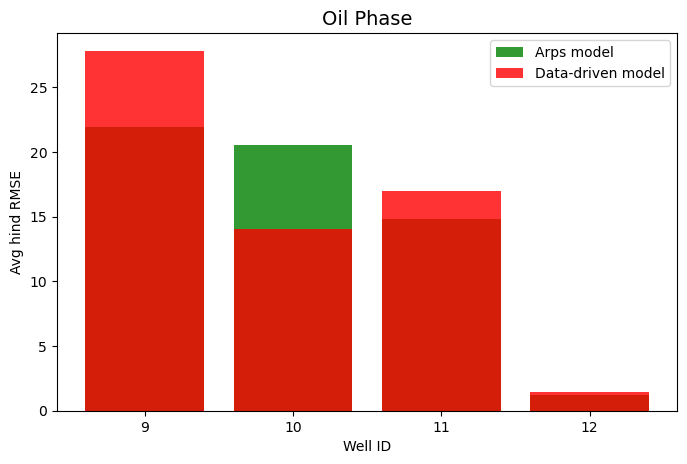

In [37]:
phase='OIL' ## test other phases here

plt.figure(figsize=[8,5])
x=np.unique(df_rmse_4['Well ID'])
y1=df_arps_4['Average_hind_rmse'].loc[df_arps_4['Phase']==phase]
y2=df_rmse_4['Average_hind_rmse'].loc[df_rmse_4['Phase']==phase]
plt.bar(x, y1, color='g',alpha=0.8)
plt.bar(x, y2, color='r',alpha=0.8)
plt.xlabel('Well ID')
plt.xticks(np.arange(9,13,step=1))
plt.ylabel('Avg hind RMSE')
plt.legend(['Arps model', 'Data-driven model'], loc='upper right')
plt.title('Oil Phase', fontsize=14)

Text(0.5, 1.0, 'Gas Phase')

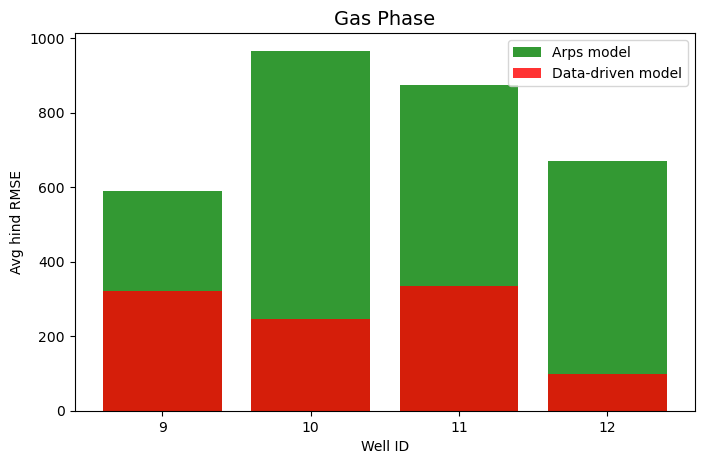

In [38]:
phase='GAS' ## test other phases here

plt.figure(figsize=[8,5])
x=np.unique(df_rmse_4['Well ID'])
y1=df_arps_4['Average_hind_rmse'].loc[df_arps_4['Phase']==phase]
y2=df_rmse_4['Average_hind_rmse'].loc[df_rmse_4['Phase']==phase]
plt.bar(x, y1, color='g',alpha=0.8)
plt.bar(x, y2, color='r',alpha=0.8)
plt.xlabel('Well ID')
plt.xticks(np.arange(9,13,step=1))
plt.ylabel('Avg hind RMSE')
plt.legend(['Arps model', 'Data-driven model'], loc='upper right')
plt.title('Gas Phase', fontsize=14)

In [69]:
## hyper-parameter tuning for 6 month hindcasting for oil phase (where performance is particularly poor)

def train_RF(n_est, depth):
    rf = RandomForestRegressor(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(trainx, trainy)
    yhat = rf_model.predict(testx)
    rmse= np.sqrt(np.mean((testy - yhat) ** 2))
    print('Est: {} / Depth: {} ----RMSE: {}'.format(n_est, depth, round(rmse,  3)))
                                                                                          

In [70]:
month=30
n_days=5*month
phase='OIL'
wells=[9,11,12]


for wid in wells:
    print ('Well:', wid)
    train, test=get_history(wid=wid,n_days=n_days,phase=phase)
    trainx=train.values[:,2].reshape(len(train), 1)
    trainy=train.values[:,1].reshape(len(train), 1)
    testx=test.values[:,2].reshape(len(test), 1)
    testy=test.values[:,1].reshape(len(test), 1)
    for n_est in [100, 200, 400]:
        for depth in [10, 30, 50, None]:
            train_RF(n_est, depth)


Well: 9
Est: 100 / Depth: 10 ----RMSE: 76.224
Est: 100 / Depth: 30 ----RMSE: 72.013
Est: 100 / Depth: 50 ----RMSE: 72.217
Est: 100 / Depth: None ----RMSE: 71.537
Est: 200 / Depth: 10 ----RMSE: 73.4
Est: 200 / Depth: 30 ----RMSE: 71.931
Est: 200 / Depth: 50 ----RMSE: 75.088
Est: 200 / Depth: None ----RMSE: 69.131
Est: 400 / Depth: 10 ----RMSE: 70.45
Est: 400 / Depth: 30 ----RMSE: 70.009
Est: 400 / Depth: 50 ----RMSE: 71.303
Est: 400 / Depth: None ----RMSE: 70.374
Well: 11
Est: 100 / Depth: 10 ----RMSE: 28.529
Est: 100 / Depth: 30 ----RMSE: 30.306
Est: 100 / Depth: 50 ----RMSE: 30.237
Est: 100 / Depth: None ----RMSE: 29.914
Est: 200 / Depth: 10 ----RMSE: 28.209
Est: 200 / Depth: 30 ----RMSE: 30.443
Est: 200 / Depth: 50 ----RMSE: 30.469
Est: 200 / Depth: None ----RMSE: 30.55
Est: 400 / Depth: 10 ----RMSE: 28.769
Est: 400 / Depth: 30 ----RMSE: 31.004
Est: 400 / Depth: 50 ----RMSE: 30.945
Est: 400 / Depth: None ----RMSE: 30.572
Well: 12
Est: 100 / Depth: 10 ----RMSE: 3.585
Est: 100 / Depth:

In [57]:
df_prod.loc[(df_prod['Well ID']==wid) & (df_prod['DAYS'].between(n_days, n_days+30, inclusive=True)==True)]

,Well ID,DAYS,OIL,GAS,WATER
4096,10,510,53.147745,2714.884354,106.000000
4097,10,511,46.488059,2632.161827,89.000000
4098,10,512,52.273919,2697.110124,116.000000
4099,10,513,49.478346,2716.479187,108.000000
4100,10,514,44.469025,2686.089841,110.000000
4101,10,515,49.091476,2698.595610,101.000000
4102,10,516,52.629654,2706.860282,70.000000
4103,10,517,55.651810,2693.972209,116.000000
4104,10,518,63.557977,2605.862495,96.000000
4105,10,519,58.680448,2586.246005,113.000000


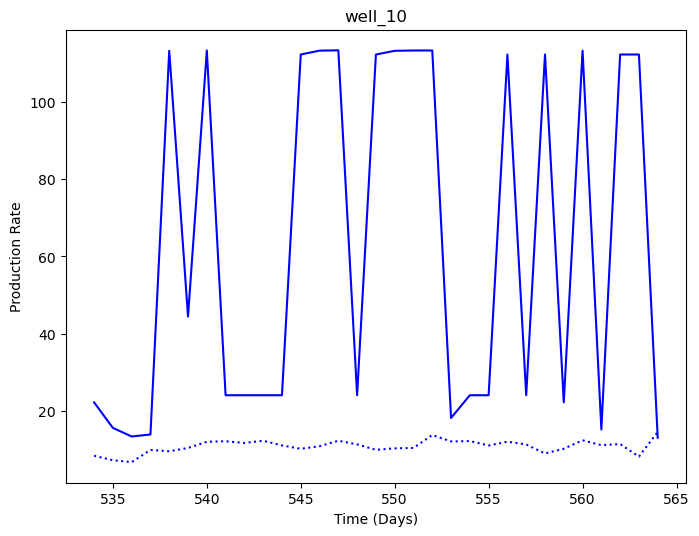

In [61]:
## demo of well 10 oil phase using Random Forest

month=30
n_days=17*month
phase='OIL'
wid=10

## given production data
#t = df_prod['DAYS'].loc[df_prod['Well ID']==wid & df_prod['DAYS'].between(n_days-month, n_days, inclusive=True)].values
#q = df_prod[phase].loc[df_prod['Well ID']==wid & df_prod['DAYS'].between(n_days-month, n_days, inclusive=True)].values

## forecasted production for 18 months
train, test=get_history(wid=wid,n_days=n_days,phase=phase)
trainx=train.values[:,2].reshape(len(train), 1)
trainy=train.values[:,1].reshape(len(train), 1)
testx=test.values[:,2].reshape(len(test), 1)
testy=test.values[:,1].reshape(len(test), 1)
rf=RandomForestRegressor(n_estimators=500)
rf.fit(trainx, trainy)
yhat=rf.predict(testx)
    

plt.figure(figsize=[8,6])
plt.plot(test.values[:,0], testy, color='b', linestyle='dotted')
plt.plot(test.values[:,0], yhat, color='b', linestyle='solid')
plt.xlabel('Time (Days)')
plt.ylabel('Production Rate')
plt.title('well_%s'%wid)
plt.show()

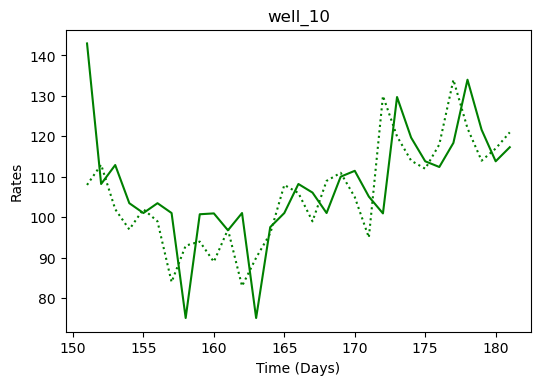

In [17]:
show_fit(t, q, yhat, 10)